<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Разреженные данные, онлайн-обучение</center>
## <center>Часть 2. Классификация отзывов к фильмам с SVM и логистической регрессией</center>

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](https://yadi.sk/d/Tg1Tflur333iLr). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# поменяйте путь к файлу
# reviews_train = load_files(
#     "/Users/y.kashnitsky/Yandex.Disk.localized/ML/data/imdb_reviews/train/"
# )
# text_train, y_train = reviews_train.data, reviews_train.target
data = pd.read_csv(
    '/content/drive/MyDrive/Colab/mlcourse_ai_russian/topic08_sgd_hashing_vowpal_wabbit/IMDB_Dataset.csv'
)
reviews_train = data[:data.shape[0]//2]
text_train, y_train = reviews_train.review, reviews_train.sentiment

In [ ]:
print("Number of documents in training data: %d" % len(text_train))
y_train = y_train.apply(lambda x: 1 if x == 'positive' else 0)
print(np.bincount(y_train))

Number of documents in training data: 25000
[12526 12474]


In [ ]:
# поменяйте путь к файлу
# reviews_test = load_files(
#     "/Users/y.kashnitsky/Yandex.Disk.localized/ML/data/imdb_reviews/test/"
# )
# text_test, y_test = reviews_test.data, reviews_test.target
reviews_test = data[data.shape[0]//2:]
text_test, y_test = reviews_test.review, reviews_train.sentiment
print("Number of documents in test data: %d" % len(text_test))
y_test = y_test.apply(lambda x: 1 if x == 'positive' else 0)
print(np.bincount(y_test))

Number of documents in test data: 25000
[12526 12474]


**Пример отзыва и соответствующей метки.**

In [ ]:
text_train[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [ ]:
y_train[1]  # плохой отзыв

1

In [ ]:
text_train[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
y_train[2]  # хороший отзыв

1

**Идея "мешка слов"**

<img src="../../img/bag_of_words.svg" width=80%>

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [ ]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

76496

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [ ]:
# print(cv.get_feature_names()[:50])
# print(cv.get_feature_names()[50000:50050])
print(cv.get_feature_names_out()[:50])
print(cv.get_feature_names_out()[50000:50050])

['00' '000' '00000001' '00001' '001' '003830' '0069' '007' '009' '00am'
 '00o' '00pm' '00s' '01' '0126' '01pm' '02' '029' '03' '04' '041' '05'
 '050' '06' '06th' '07' '08' '087' '089' '08th' '09' '0tt' '10' '100'
 '1000' '10000' '10000000000' '10000000000000' '1000lb' '1000s' '1001'
 '1004' '100b' '100bt' '100ibs' '100k' '100m' '100miles' '100min' '100mph']
['pedantry' 'peddle' 'peddled' 'peddler' 'peddlers' 'peddles' 'peddling'
 'pedecaris' 'pedecarises' 'pederast' 'pederson' 'pedestal' 'pedestrian'
 'pedestrians' 'pediatrician' 'pedicab' 'pedicure' 'pedigree' 'pedigreed'
 'pedometers' 'pedophile' 'pedophiles' 'pedophilia' 'pedophiliac'
 'pedophilic' 'pedro' 'pee' 'peeble' 'peebles' 'peed' 'peeing' 'peek'
 'peekaboo' 'peeked' 'peeking' 'peeks' 'peel' 'peeled' 'peeling' 'peels'
 'peen' 'peens' 'peep' 'peeped' 'peepers' 'peephole' 'peeping' 'peeples'
 'peer' 'peerage']


**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [ ]:
X_train = cv.transform(text_train)
X_train

<25000x76496 sparse matrix of type '<class 'numpy.int64'>'
	with 3416775 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [ ]:
print(text_train[19726])

I have read both the book and saw the movie today. The storyline is so powerful that almost any script or screenplay would have done justice to it. So nothing much there. However, this is still a beautiful movie because it makes one think and feel, just like the book. Watching it is not like watching a documentary on a failed state and feeling sympathetic towards people suffering under an oppressive regime, but is like watching any other common man's story unfold, across generations, across continents. Amir's cowardice, his guilt, his dilemmas and finally his choosing a way of redemption could have been a story of any of us. There isn't a single infallible character to look up to and idolize but all of them are gray, just like all of us.<br /><br />Another important observation is that the movie does a great job of chronicling the lives of Afghans through the twenty some years of turbulent political scenarios. The vibrant, care-free childhood represents Kabul before the Russian invasio

In [ ]:
X_train[19726].nonzero()[1]

array([ 1306,  1655,  1692,  1695,  2132,  2735,  2855,  3036,  3159,
        3265,  3352,  3633,  3706,  3799,  4214,  4846,  6616,  6640,
        6727,  6764,  8592,  8812,  8989, 10171, 10655, 10945, 11942,
       12395, 12398, 12574, 12691, 12861, 12954, 13817, 14034, 14464,
       14594, 14885, 15455, 15610, 18280, 18317, 18410, 18883, 19610,
       19805, 19858, 19898, 20059, 21345, 22116, 23533, 23796, 23944,
       24047, 24610, 24612, 24614, 25092, 25922, 26432, 27644, 28526,
       29105, 29131, 29651, 30641, 30762, 31736, 32503, 32648, 33143,
       33160, 33566, 33672, 34115, 34918, 35008, 35247, 35303, 35342,
       36074, 36364, 36491, 36493, 36581, 36994, 38805, 38908, 39538,
       39697, 39872, 40155, 41235, 41406, 42282, 42703, 43723, 45073,
       45170, 45278, 45503, 47046, 47066, 47423, 47477, 47653, 47900,
       47919, 48100, 48136, 48409, 48468, 50211, 51662, 51765, 52289,
       53835, 54747, 54916, 55344, 55584, 55881, 56202, 56722, 58096,
       58930, 59109,

In [ ]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 1306,  1655,  1692,  1695,  2132,  2735,  2855,  3036,  3159,
         3265,  3352,  3633,  3706,  3799,  4214,  4846,  6616,  6640,
         6727,  6764,  8592,  8812,  8989, 10171, 10655, 10945, 11942,
        12395, 12398, 12574, 12691, 12861, 12954, 13817, 14034, 14464,
        14594, 14885, 15455, 15610, 18280, 18317, 18410, 18883, 1

**Преобразуем так же тестовую выборку.**

In [ ]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию и линейный SVM.**

In [ ]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 99.8 ms, sys: 190 ms, total: 290 ms
Wall time: 5.23 s


LogisticRegression(n_jobs=-1, random_state=7)

In [ ]:
%%time
svm = LinearSVC(random_state=7)
svm.fit(X_train, y_train)

CPU times: user 9.36 s, sys: 40.5 ms, total: 9.4 s
Wall time: 9.48 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=7)

**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [ ]:
round(logit.score(X_train, y_train), 3), round(svm.score(X_train, y_train), 3)

(0.98, 1.0)

In [ ]:
round(logit.score(X_test, y_test), 3), round(svm.score(X_test, y_test), 3)

(0.501, 0.499)

In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

In [ ]:
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();

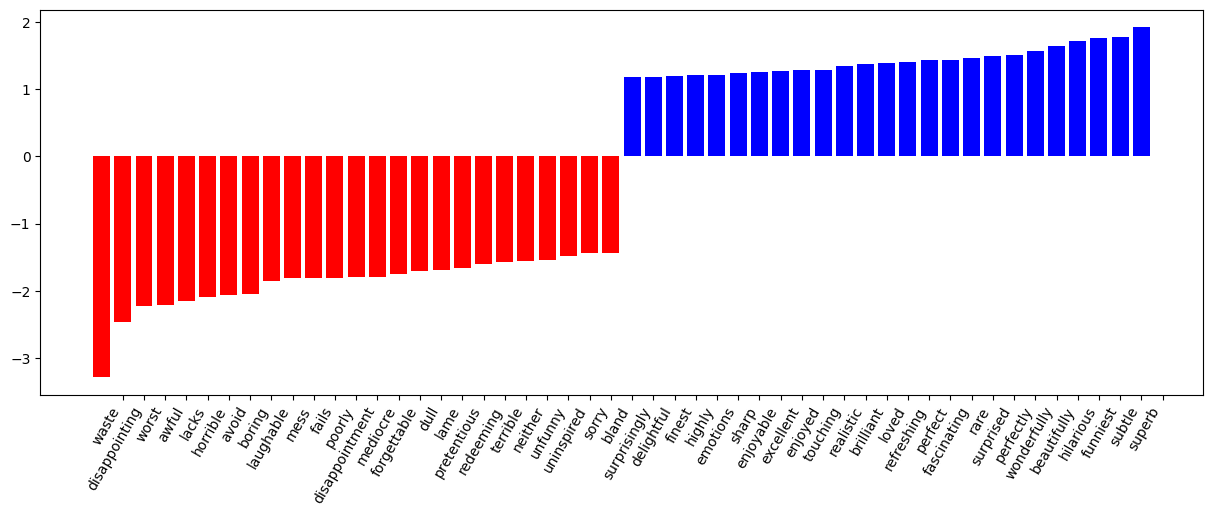

In [ ]:
visualize_coefficients(logit, cv.get_feature_names_out())

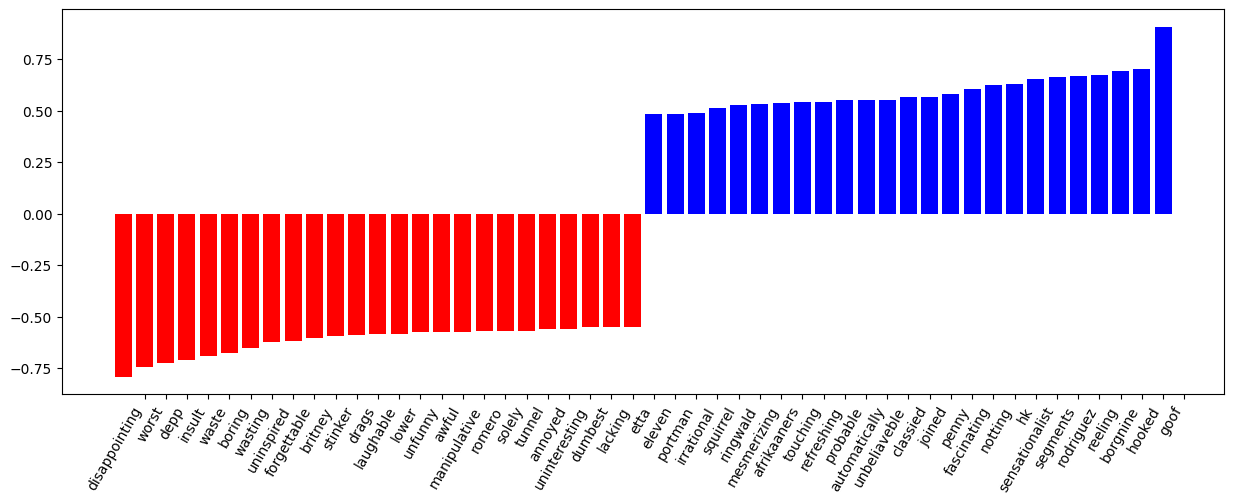

In [ ]:
visualize_coefficients(svm, cv.get_feature_names_out())

**Подберем коэффициент регуляризации для логистической регрессии.**

In [ ]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(), LogisticRegression(n_jobs=-1, random_state=7)
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.501
CPU times: user 10.2 s, sys: 162 ms, total: 10.4 s
Wall time: 15 s


In [ ]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True)

grid_logit.fit(text_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 7.93 s, sys: 1.21 s, total: 9.13 s
Wall time: 3min 46s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

**Лучшее значение C и соответствующее качество на кросс-валидации.**

In [ ]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8822798028311821)

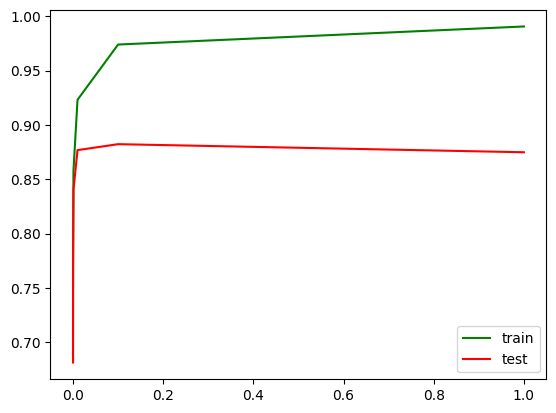

In [ ]:
plot_grid_scores(grid_logit, "logisticregression__C")

**То же самое для LinearSVC.**

In [ ]:
%%time
text_pipe_svm = make_pipeline(CountVectorizer(), LinearSVC(random_state=7))

text_pipe_svm.fit(text_train, y_train)
print(text_pipe_svm.score(text_test, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.49916
CPU times: user 27.6 s, sys: 169 ms, total: 27.7 s
Wall time: 36.9 s


In [ ]:
%%time
param_grid_svm = {"linearsvc__C": np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(text_pipe_svm, param_grid_svm, cv=3, n_jobs=-1, return_train_score=True)

grid_svm.fit(text_train, y_train);

CPU times: user 13.8 s, sys: 1.06 s, total: 14.9 s
Wall time: 3min 36s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(random_state=7))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

In [ ]:
grid_svm.best_params_, grid_svm.best_score_

({'linearsvc__C': 0.01}, 0.8817997980298382)

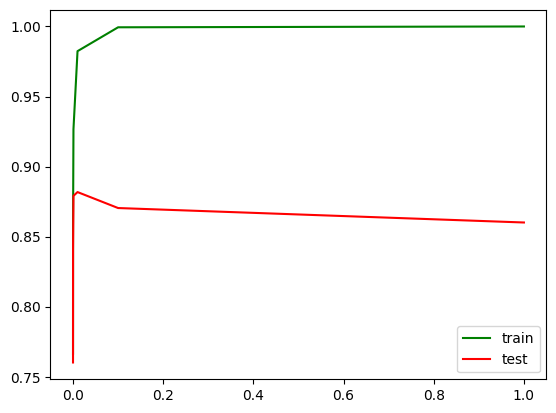

In [ ]:
plot_grid_scores(grid_svm, "linearsvc__C")

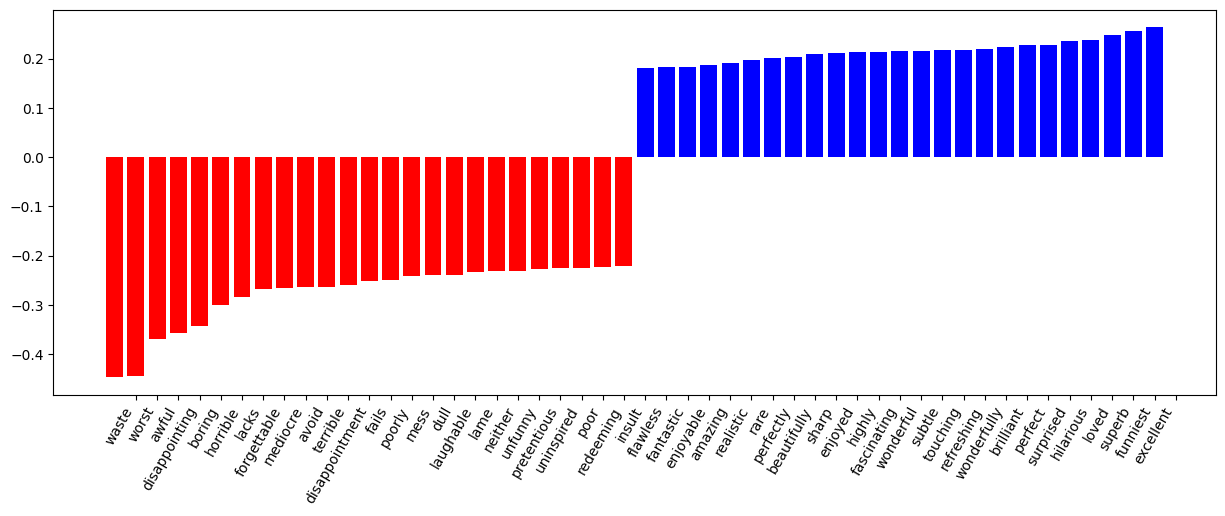

In [ ]:
visualize_coefficients(
    grid_svm.best_estimator_.named_steps["linearsvc"],
    grid_svm.best_estimator_.named_steps["countvectorizer"].get_feature_names_out(),
)

На валидационной выборке:

In [ ]:
grid_logit.score(text_test, y_test), grid_svm.score(text_test, y_test)

(0.50048, 0.50148)

## TF-IDF

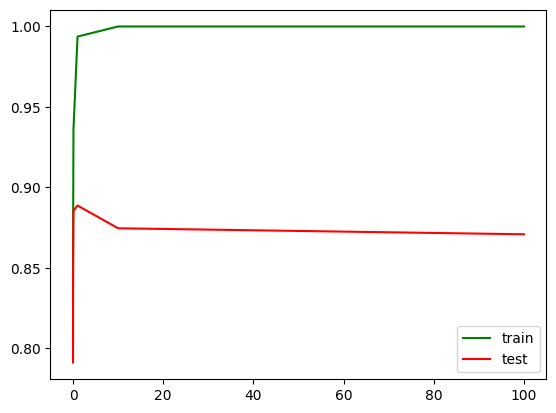

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_pipe = make_pipeline(TfidfVectorizer(), LinearSVC())

param_grid = {"linearsvc__C": np.logspace(-3, 2, 6)}
grid_tfidf = GridSearchCV(tfidf_pipe, param_grid, cv=3, n_jobs=-1, return_train_score=True)
grid_tfidf.fit(text_train, y_train)
plot_grid_scores(grid_tfidf, "linearsvc__C")

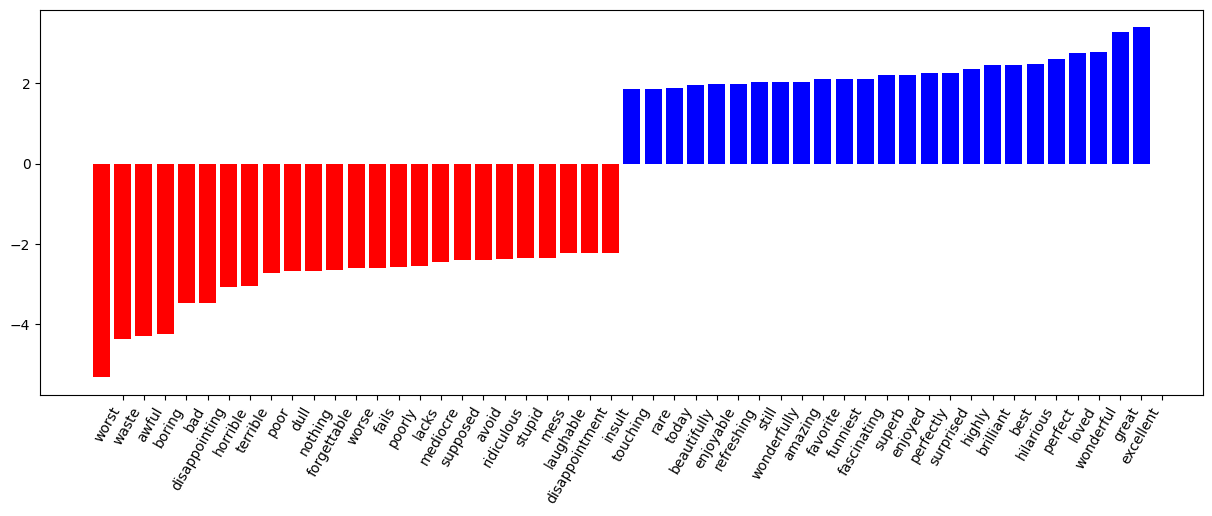

In [ ]:
visualize_coefficients(
    grid_tfidf.best_estimator_.named_steps["linearsvc"],
    grid_tfidf.best_estimator_.named_steps["tfidfvectorizer"].get_feature_names_out(),
)

In [ ]:
grid_tfidf.best_score_, grid_tfidf.best_params_

(0.8887599036478857, {'linearsvc__C': 1.0})

## N-граммы

In [ ]:
%%time
text_pipe = make_pipeline(CountVectorizer(), LinearSVC())

param_grid = {"linearsvc__C": [0.01, 0.1, 1], "countvectorizer__ngram_range": [(1, 2)]}

grid_bigram = GridSearchCV(text_pipe, param_grid, cv=3, return_train_score=True)

grid_bigram.fit(text_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

CPU times: user 7min 50s, sys: 4.82 s, total: 7min 55s
Wall time: 8min 3s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('linearsvc', LinearSVC())]),
             param_grid={'countvectorizer__ngram_range': [(1, 2)],
                         'linearsvc__C': [0.01, 0.1, 1]},
             return_train_score=True)

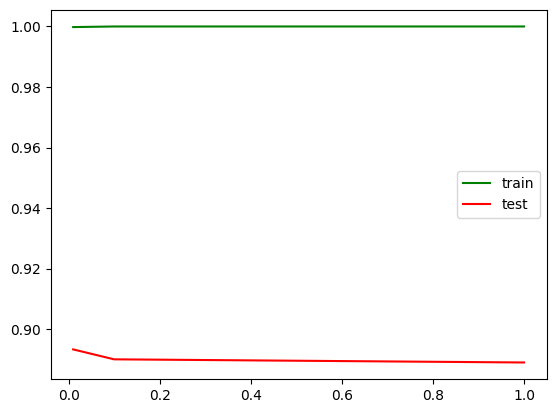

In [ ]:
plot_grid_scores(grid_bigram, "linearsvc__C")

In [ ]:
grid_bigram.best_score_

0.8933197596682364